Dhananjay Tiwari,
Ph.D. Mechanical Engineering,
Mechanical Engineering Laboratory, 1204
University of Illinois at Urbana Champaign

This file has the code for implementation of FLPO optimization problem using using scipy optimizers

In [164]:
# include libraries and dependencies
import numpy as np # Computational python programming and not include this? Can't happen!
import matplotlib.pyplot as plt # module to make plots
from scipy import optimize # optimization module in scipy
from scipy.optimize import minimize # minimize function using various algorithms
from scipy.optimize import Bounds # to define bounds on decision variables
from scipy.optimize import LinearConstraint # to define linear constraints on decision variables
from scipy.optimize import SR1 # used for quasi-Newton Hessian approximation
import time # used to measure time taken by the code segments

In [165]:
# create FLPO class and define its associated functions
class FLPO():

    # define data members of the class
    N : int # number of vehicles
    M : int # number of nodes
    K : int # number of stages
    uav_id : list # vehicle indices
    node_id : list # facility indices
    stop_id : list # destination id
    Adj_mat : np.ndarray # adjacency matrix of the nodes
    uav_init : list # list of initial nodes of all the uavs
    uav_stop : list # list of stop nodes of all the uavs
    schedule : dict # node parameters
    num_param : dict # number of parameters
    node_lcn : np.ndarray # array of node locations
    node_tol : np.ndarray # array of node collision avoidance tolerances
    speed_lim : np.ndarray # array of minimum and maximum speed limits of vehicles
    beta : float # annealing parameter

    dt_min : list # list of matrices of the minimum time taken to travel along the paths by all the vehicles
    dt_max : list # list of matrices of the maximum time taken to travel along the paths by all the vehicles

    stages : list # FLPO stages, K elements
                  #   Nx1  (M+1)x1  (M+1)x1   (M+1)x1    (M+1)x1       1x1
                  #   stg0   stg1    stg2     stg3 . . . . stgK-2     stgK-1
                  #    0      0        0        0  . . . .  0               
                  #    1      1        1        1  . . . .  1
                  #    2      2        2        2  . . . .  2          dest
                  #    .      .        .        .  . . . .  .
                  #    .      .        .        .  . . . .  .
                  #    .      M-1      M-1      M-1  . . .  M-1
                  #    .      dest    dest     dest  . . .  dest
                  #    N-1    

    can_transit : list # list of list of arrays
                  #  --------------                                                                           --------------
                  # |          stagewise path connections for vehicles i = 0,1, . . , N-1                                   |
                  # |    -----                                                                     -----                    |
                  # |   |                                                                               |                   |
                  # |   |   stg0 ----> stg1 ----------> stg2 -----> . . . . ----> stg(K-1) -----> stgK  |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |  . . . . .        |
                  # |   |  1x|stg1|  |stg1|x|stg2|    |stg2|x|stg3|   . . . .    |stg(K-1)|x|stgK|      |                   |
                  # |   |  matrix     matrix            matrix  . . . . . . .      matrix               |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |    -----                                                                     -----                    |
                  #  -------------                                                                            --------------


    asn_pb : list # list of list of arrays
                  #  --------------                                                                           --------------
                  # |          stagewise probability associations for vehicles i = 0,1, . . , N-1                           |
                  # |    -----                                                                     -----                    |
                  # |   |                                                                               |                   |
                  # |   |   stg0 ----> stg1 ----------> stg2 -----> . . . . ----> stg(K-1) -----> stgK  |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |  . . . . .        |
                  # |   |  1x|stg1|  |stg1|x|stg2|    |stg2|x|stg3|   . . . .    |stg(K-1)|x|stgK|      |                   |
                  # |   |  matrix     matrix            matrix  . . . . . . .      matrix               |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |    -----                                                                     -----                    |
                  #  -------------                                                                            --------------


    cost_transit : list # list of list of arrays
                  #  --------------                                                                           --------------
                  # |          stagewise transition costs for vehicles i = 0,1, . . , N-1                                   |
                  # |    -----                                                                     -----                    |
                  # |   |                                                                               |                   |
                  # |   |   stg0 ----> stg1 ----------> stg2 -----> . . . . ----> stg(K-1) -----> stgK  |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |  . . . . .        |
                  # |   |  1x|stg1|  |stg1|x|stg2|    |stg2|x|stg3|   . . . .    |stg(K-1)|x|stgK|      |                   |
                  # |   |  matrix     matrix            matrix  . . . . . . .      matrix               |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |    -----                                                                     -----                    |
                  #  -------------                                                                            --------------


    entropy_transit : list # list of list of arrays
                  #  --------------                                                                           --------------
                  # |          stagewise np.log of transition probabilities for vehicles i = 0,1, . . , N-1                 |
                  # |    -----                                                                     -----                    |
                  # |   |                                                                               |                   |
                  # |   |   stg0 ----> stg1 ----------> stg2 -----> . . . . ----> stg(K-1) -----> stgK  |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |  . . . . .        |
                  # |   |  1x|stg1|  |stg1|x|stg2|    |stg2|x|stg3|   . . . .    |stg(K-1)|x|stgK|      |                   |
                  # |   |  matrix     matrix            matrix  . . . . . . .      matrix               |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |    -----                                                                     -----                    |
                  #  -------------                                                                            --------------


    def __init__(self, N, M, Adj_mat, node_lcn, node_tol, speed_lim, init_nodes, stop_nodes, beta):
        # this function intializes the FLPO structure with assigned values
        
        # UAVs, nodes and stopping state indices
        self.N = N # initialize the number of vehicles (user defined)
        self.M = M # initialize the number of nodes (user defined)
        self.K = self.M + 2 # 1 initial stage + #intermediate stages equal to the number of facilities + 1 final stage
        self.uav_id = list(range(N)) # 0 1 2 . . . N-1
        self.node_id = list(range(N, N+M)) # N N+1 . . . N+M-1
        self.stop_id = list(range(N+M, N+M+1)) # N+M
        self.Adj_mat = Adj_mat # initialize the adjacency matrix (user defined)
        self.uav_init = init_nodes # initialize initial nodes for all the UAVs (to be given by the user)
        self.uav_stop = stop_nodes # initialize stop node for all the UAVs (to be given by the user)
        self.schedule = np.zeros([M, N]) # all M nodes have N components for each vehicle
        self.dim_schedule = M*N # the total numbe of parameters is number of nodes times the number of vehicles
        self.node_lcn = node_lcn # node locations (user defined)
        self.node_tol = node_tol # node collision avoidance tolerances (user defined)
        self.speed_lim = speed_lim # minimum and maximum speed of vehicles (user defined)
        self.beta = beta # initialize the annealing parameter (user defined)

        # calculate the minimum and the maximum times taken by vehicles to travel along all possible paths
        self.dt_min = [np.zeros([self.M,self.M]) for el in range(self.N)]
        self.dt_max = [np.zeros([self.M,self.M]) for el in range(self.N)]
        # iterate over all the vehicles
        for n in range(self.N):
            # iterate over all the nodes
            for i in range(self.M):
                # iterate over all the nodes:
                for j in range(self.M):
                    # if Adj_mat[i, j] == 1:
                    self.dt_min[n][i, j] = np.linalg.norm(node_lcn[i] - node_lcn[j])/speed_lim[n,1]
                    self.dt_max[n][i, j] = np.linalg.norm(node_lcn[i] - node_lcn[j])/speed_lim[n,0]
                    # else:
                        # self.dt_min[n][i, j] = np.linalg.norm(node_lcn[i] - node_lcn[j])/0.2
                        # self.dt_max[n][i, j] = np.linalg.norm(node_lcn[i] - node_lcn[j])/0.1   

        # define the structure of the stages and the elements in them
        self.stages = [0 for element in range(self.K)] # initialize list stages. Each 0 to be replaced with a column vector
        for stg in range(self.K):
            if stg == 0:
                # initial stage consisting of nodes
                self.stages[stg] = self.uav_id # Nx1 array
            elif stg == self.K-1:
                # final stage consists of only stopping state
                self.stages[stg] = self.stop_id # 1x1 array
            else:
                # other stages consist of facilities and destination
                self.stages[stg] = self.node_id + self.stop_id # (M+1) x 1 array
        
        # initialize association probabilities and cost transitions
        self.can_transit = [[0 for element1 in range(self.K-1)] for element2 in range(N)]
        self.asn_pb = [[0 for element1 in range(self.K-1)] for element2 in range(N)]
        self.cost_transit = [[0 for element1 in range(self.K-1)] for element2 in range(N)]
        self.entropy_transit = [[0 for element1 in range(self.K-1)] for element2 in range(N)]
        for n in range(N): # iteration over each node in the initial stage
            for stg in range(self.K-1): # iteration goes until the penultimate stage
                next_stage = self.stages[stg+1] # get the next stage nodes
                # initialize probabilities as ones (normalized in the next step)
                if stg == 0:
                    id_n = self.uav_id.index(n) # get the vehicle index
                    print(self.node_id)
                    id_i = self.node_id.index(self.uav_init[id_n]) # get the start node of the vehicle
                    # stagewise adjacency matrix
                    self.can_transit[n][stg] = Adj_mat[id_i, :]
                    # a uniform distribution only on the connected nodes
                    self.asn_pb[n][stg] = np.multiply(np.ones([1, len(next_stage)]), Adj_mat[id_i, :])
                    # normal distribution
                    # self.asn_pb[n][stg] = np.multiply(np.random.rand(1, len(next_stage)), row) 
                    # normalize associations
                    self.asn_pb[n][stg] = self.asn_pb[n][stg]/self.asn_pb[n][stg].sum(axis = 1)[:, None] 
                    # transition cost matrix
                    self.cost_transit[n][stg] = np.zeros([1, len(self.stages[stg+1])])
                    # transition entropy matrix
                    self.entropy_transit[n][stg] = np.zeros([1, len(self.stages[stg+1])])
                elif stg < self.K-2:
                    # stagewise adjacency matrix
                    self.can_transit[n][stg] = Adj_mat
                    # uniform distribution only on the connected nodes
                    self.asn_pb[n][stg] = np.multiply(np.ones([len(self.stages[stg]), len(self.stages[stg+1])]), Adj_mat) 
                    # normal distribution
                    # self.asn_pb[n][stg] = np.multiply(np.random.rand(len(self.stages[stg]), len(self.stages[stg+1])), Adj_mat)
                    # normalize
                    self.asn_pb[n][stg] = self.asn_pb[n][stg]/self.asn_pb[n][stg].sum(axis = 1)[:, None]
                    # transition cost matrix
                    self.cost_transit[n][stg] = np.zeros([len(self.stages[stg]), len(self.stages[stg+1])])
                    # transition entropy matrix
                    self.entropy_transit[n][stg] = np.zeros([len(self.stages[stg]), len(self.stages[stg+1])])
                else:
                    # stagewise adjacency matrix
                    self.can_transit[n][stg] = np.ones([len(self.stages[stg]), len(self.stages[stg+1])])
                    # uniform distribution
                    self.asn_pb[n][stg] = np.ones([len(self.stages[stg]), len(self.stages[stg+1])])
                    # normal distribution
                    # self.asn_pb[n][stg] = np.random.rand(len(self.stages[stg]), len(self.stages[stg+1]))
                    # normalize
                    self.asn_pb[n][stg] = self.asn_pb[n][stg]/self.asn_pb[n][stg].sum(axis = 1)[:, None]
                    # transition cost matrix
                    self.cost_transit[n][stg] = np.zeros([len(self.stages[stg]), len(self.stages[stg+1])])
                    # transition entropy matrix
                    self.cost_transit[n][stg] = np.zeros([len(self.stages[stg]), len(self.stages[stg+1])])

        print('\n -- FLPO Initialized -- ')


    # assign an initial node to a UAV
    def set_init_node(self, uav, init_node):
        id_uav = self.uav_id.index(uav) # get the UAV index
        self.uav_init[id_uav] = init_node # assign the initial node to the corresponding index
    

    # access the initial node of a UAV
    def get_init_node(self, uav):
        id_uav = self.uav_id.index(uav) # get the UAV index
        return self.uav_init[id_uav] # return the corresponding UAV initial node
    

    # assign a terminal node to a UAV
    def set_stop_node(self, uav, stop_node):
        id_uav = self.uav_id.index(uav) # get the UAV index
        self.uav_stop[id_uav] = stop_node # assign the terminal node to the corresponding index


    # access the terminal node of a UAV
    def get_stop_node(self, uav):
        id_uav = self.uav_id.index(uav) # get the UAV index
        return self.uav_stop[id_uav] # return the corresponding UAV terminal node
    

    # a function to apply quadratic penalty on the time schedules
    def quad_penalty(self, x, xmin, xmax, factor):
        '''
        input : x : argument of the function
                xmin : minimum bound on x
                xmax : maximum bound on x
        output : function value as penalty value
        '''
        # parameter to adjust penalty steepness
        a = factor
        fx = 0
        if x < xmin:
            fx = a*x**2 + (1 - 2*a*xmin)*x + a*xmin**2
        elif (x-xmin)*(x-xmax) <= 0:
            fx = x
        elif x > xmax:
            fx = a*x**2 + (1 - 2*a*xmax)*x + a*xmax**2
        return fx

    # define stage transportation cost for each node        
    def cost_stage_transit(self, n, i, j):
        # this function gives the value of stage transition cost for node n
        # from node i in stage stg to node j in stage stg+1
        # for now the cost is defined based on the facility schedules

        t = self.schedule # a 2D matrix with each row representing a facility, and every column representing a node
        
        if i in self.node_id and j in self.node_id:
            # time taken to move from node i to node j by vehicle n in intermediate nodes
            id_i = self.node_id.index(i)
            id_j = self.node_id.index(j)
            id_n = self.uav_id.index(n)
            if j == i:
                cost = 100000 # high self hopping cost
            else:
                epsilon = 0.001
                cost = self.quad_penalty(t[id_j, id_n] - t[id_i, id_n],
                                         self.dt_min[id_n][id_i, id_j],
                                         self.dt_max[id_n][id_i, id_j], 
                                         factor=20) / np.maximum(self.Adj_mat[id_i,id_j], epsilon)
                # cost = t[id_j, id_n] - t[id_i, id_n] + \
                #     np.maximum(0, (t[id_j, id_n] - t[id_i, id_n] - self.dt_min[id_n][id_i, id_j])*(t[id_j, id_n] - t[id_i, id_n] - self.dt_max[id_n][id_i, id_j]))**2
        elif i in self.node_id and j in self.stop_id:
            # if transition is from a node to stopping state
            if i == self.get_stop_node(n):
                # if the current node is the destination of vehicle n then zero cost
                cost = 0
            else:
                # else high penalty
                cost = 100000        
        elif i in self.stop_id and j in self.node_id:
            # if transition is from a stopping state to a node
            cost = 100000 # the penalty is high
        elif i in self.stop_id and j in self.stop_id:
            # zero cost for stage-transition from stop to stop
            cost = 0

        return cost


    def cost_vehicle_transit(self, n):
        '''
        Input : UAV number
        Output : Computes a list of stagewise transition cost matrices, returns None
        '''
        # vectorize the elementwise stagewise transition cost function
        func = np.vectorize(self.cost_stage_transit, otypes=[np.float64])

        # mesh stage 0 cost transit matrix
        i = self.get_init_node(n)
        mesh = np.meshgrid(i, self.stages[1])
        node_i = mesh[0].flatten()
        node_j = mesh[1].flatten()
        self.cost_transit[n][0] = func(n, node_i, node_j).reshape((1, self.M+1))

        # mesh for intermediate stages cost transit matrix
        mesh = np.meshgrid(self.node_id+self.stop_id, self.node_id+self.stop_id)
        node_i = mesh[1].flatten()
        node_j = mesh[0].flatten()
        self.cost_transit[n][1:self.K-2] = [func(n, node_i, node_j).reshape((self.M+1, self.M+1))]*(self.K-3)

        # mesh for penultimate stage cost transit matrix
        mesh = np.meshgrid(self.node_id+self.stop_id, self.stop_id)
        node_i = mesh[0].flatten()
        node_j = mesh[1].flatten()
        self.cost_transit[n][self.K-2] = func(n, node_i, node_j).reshape((self.M+1, 1))
        return None
    

    def entropy_vehicle_transit(self, n):
        '''
        Input : UAV number
        Output : Computes a list of stagewise transition entropy matrices, returns None
        '''

        for stg in range(self.K-1):
            self.entropy_transit[n][stg] = np.np.log(self.asn_pb[n][stg])
            
        return None
    

    # function to calculate distortion in matricized form
    def calc_distortion(self, n):
        '''
        input: The UAV number
        output: out_C: K+1 numpy arrays with shape[1]=1, indicating the total cost of nodes
                out_H: 
        '''
        self.cost_vehicle_transit(n)
        self.entropy_vehicle_transit(n)

        D_s = self.cost_transit[n]
        L_s = self.entropy_transit[n]
        P_s = self.asn_pb[n]
        
        K = len(D_s)
        D = D_s[::-1]
        L = L_s[::-1]
        P = P_s[::-1]

        out_P = [0]*(K+1)
        out_C = [0]*(K+1)
        out_H = [0]*(K+1)
        out_P[0] = np.array([1.0]).reshape(-1,1)
        out_C[0] = np.array([0.0]).reshape(-1,1)
        out_H[0] = np.array([0.0]).reshape(-1,1)
        
        for i in range(1,K+1):
            # assigning P of each node for calculating C in the next i
            out_P[i] = (P[i-1]*np.repeat(np.transpose(out_P[i-1]),P[i-1].shape[0],axis=0)).sum(axis=1).reshape(-1,1)
            out_C[i] = (P[i-1]*(D[i-1]*np.repeat(np.transpose(out_P[i-1]),D[i-1].shape[0],axis=0)+np.repeat(np.transpose(out_C[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)
            out_H[i] = (P[i-1]*(L[i-1]*np.repeat(np.transpose(out_P[i-1]),L[i-1].shape[0],axis=0)+np.repeat(np.transpose(out_H[i-1]),L[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)

        return out_C[-1].sum(), -out_H[-1].sum()


    # define the distortion function of a vehicle 
    def distortion(self, n): 
        # this function computes the distortion cost and entropy of a vehicle n using probability associations and parameters of nodes
        # input : vehicle index
        # output : a list of the total distortion cost and entropy
        
        # set probability associations as the gibbs distribution
        self.asn_pb_gibbs()

        if n not in self.uav_id: # check if the vehicle argument is valid or not
            print('invalid node id')
        else:
            # initialize the distortion data structure (same as stages data structure)
            D = [np.zeros(1)]
            H = [np.zeros(1)]
            D = D + [np.zeros(len(self.stages[stg])) for stg in range(1,self.K)]
            H = H + [np.zeros(len(self.stages[stg])) for stg in range(1,self.K)]

            # iterate over stages : final stage --> initial stage
            stg_ids = list(range(self.K))
            stg_ids_rev = stg_ids[::-1]
            for stg in stg_ids_rev:
                # iterating condition for intermediate stages
                if stg > 0:
                    # iterate over each element of the chosen stage
                    for i in self.stages[stg]:
                        id_i = self.stages[stg].index(i) # get the node index in the list
                        if stg == self.K-1: # special condition for the final stage
                            D[stg][id_i] = 0 # the terminal cost is zero
                            H[stg][id_i] = 0 # the terminal cost is zero
                        else:
                            for j in self.stages[stg+1]: # iterate over the elements of the next stage to compute iterative summation
                                id_j = self.stages[stg+1].index(j) # get the node index in the list
                                p = np.maximum(1e-20, self.asn_pb[n][stg][id_i, id_j])
                                D[stg][id_i] = D[stg][id_i] + p * (D[stg+1][id_j] + self.cost_stage_transit(n, i, j)) # dynamic programming sum
                                H[stg][id_i] = H[stg][id_i] + p * (H[stg+1][id_j] + np.log(p)) # dynamic programming sum
                # special condition for the initial stage
                elif stg == 0:
                    i = self.get_init_node(n) # the only node in stage 0 is the vehicle id
                    id_i = 0 # the id of the node is zero
                    for j in self.stages[stg+1]: # iterate over the elements of stage 1 to compute the dynamic programming sum
                        id_j = self.stages[stg+1].index(j) # get the node index in the list
                        p = np.maximum(1e-20, self.asn_pb[n][stg][id_i, id_j])
                        D[stg][id_i] = D[stg][id_i] + p * (D[stg+1][id_j] + self.cost_stage_transit(n, i, j)) # dynamic programming sum
                        H[stg][id_i] = H[stg][id_i] + p * (H[stg+1][id_j] + np.log(p)) # dynamic programming sum
        
        return D[0][0], -H[0][0]
    

    # function to flatten the association probabilities
    def flat_asn_pb(self, asn_pb):
        # this function unwraps the association probabilities into a column vector

        vec = []
        # unwrap for a vehicle, and then put them all together
        for uav_pb in asn_pb:
            for stg_pb in uav_pb:
                vec = vec + list(stg_pb.flatten())

        return vec


    # function to wrap the association probabilities into the stagewise structure initialized by the class
    def wrap_flat_asn_pb(self, vec_asn_pb):
        '''
        input : vec_asn_pb: vectorized association probabilities
        output : asn_pb: structured association probabilities
        '''

        # initialize the required structure
        asn_pb = [[0 for element1 in range(self.K-1)] for element2 in range(self.N)]

        # get the dimension of probability association for a single vehicle
        dim_uav = 0
        # iterate over the stages to compute the above required dimension
        for stg in range(self.K-1):
            if stg == 0:
                dim_uav = dim_uav + len(self.stages[stg+1])
            else:
                dim_uav = dim_uav + len(self.stages[stg])*len(self.stages[stg+1])
        
        # dim_uav times the number of vehicles should be dim of vec_asn_pb
        if dim_uav * len(self.uav_id) != int(len(vec_asn_pb)):
            print('invalid dimension of association probability vector')
        else:
            for uav in self.uav_id:
                # get the index of uav
                n = self.uav_id.index(uav)
                # slice the probability vector for the corresponding vehicle
                sliced_vec = vec_asn_pb[n*dim_uav : (n+1)*dim_uav]
                k = 0
                for stg in range(self.K-1):
                    if stg == 0:
                        asn_pb[n][stg] = np.reshape( sliced_vec[k : k + 1*len(self.stages[stg+1])] , [1, len(self.stages[stg+1])] )
                        k = k + 1*len(self.stages[stg+1])
                    else:
                        asn_pb[n][stg] = np.reshape( sliced_vec[k : k + len(self.stages[stg])*len(self.stages[stg+1])] , [len(self.stages[stg]), len(self.stages[stg+1])] )
                        k = k + len(self.stages[stg])*len(self.stages[stg+1])
        
        return asn_pb


    def flat_schedules(self, schedules):
        # this converts the original data structure of schedules (see __init__() function) into a 1D array
        return list(schedules.flatten())


    def wrap_schedules(self, vec_schedules):
        # this converts the 1D array of schedules into its original defined structure (see __init__() function)

        # first check if the dimension is correct
        dim = len(vec_schedules)
        if dim != len(self.node_id) * len(self.uav_id):
            print('invalid dimension of the parameters for time-schedule')

        schedules = np.reshape(vec_schedules, [len(self.node_id), len(self.uav_id)])

        return schedules
    

    # function counts the number of probability association variables in the problem
    def get_num_asn_pb(self):
        '''
        input : the class instance
        output : dimension of probability variables
        '''
        # get the number of probability association variables
        dim_pb = 0
        # iterate over the stages to compute the above required dimension
        for n in range(self.N):
            for stg in range(self.K-1):
                if stg == 0: # in the zeroth stage only 1 vehicle is considered and multiplied with the dimension of the stage 1
                    dim_pb = dim_pb + 1 * len(self.stages[stg+1])
                else: # otherwise the original dimensions of the current stage is multiplied with that the next one
                    dim_pb = dim_pb + len(self.stages[stg]) * len(self.stages[stg+1])

        return dim_pb
    
    
    # function to get the upper and lower bounds on the association variables
    def bounds_asn_pb(self):
        '''
        input : no external inputs
        output : returns two vectors, representing lower and upper bounds respectively
        '''
        # fetch the number of association variables
        dim_pb = self.get_num_asn_pb()
        # associations lie in the interval [0, 1]
        lb = list(np.zeros(dim_pb))
        ub = list(np.ones(dim_pb))  
    
        row_count = 0
        # iterate over the uavs
        for n in self.uav_id:
            # iterate over the stages
            for stg in range(self.K-1):
                # iterate over the current stage
                for i in self.stages[stg]:
                    # iterate over the next stage
                    for j in self.stages[stg+1]:
                        # special condition for the initial and final stages
                        if stg == 0:
                            id_i = self.node_id.index(self.get_init_node(n)) # the first node is start point of vehicle n
                            id_j = self.stages[stg+1].index(j) 
                            ub[row_count] = ub[row_count] * self.Adj_mat[id_i, id_j] # make it zero if there is no link between i and j
                            row_count = row_count + 1 # update row count
                        elif stg == self.K-2:
                            id_i = self.stages[stg].index(i)
                            id_j = self.M # the index of the stop node in Adj_mat is self.M
                            ub[row_count] = ub[row_count] * self.Adj_mat[id_i, id_j] # make zero if there is no link between i and j
                        else:
                            id_i = self.stages[stg].index(i) 
                            id_j = self.stages[stg+1].index(j)
                            ub[row_count] = ub[row_count] * self.Adj_mat[id_i, id_j] # make zero is there is no link between i and j
                            row_count = row_count + 1 # update row counts

        return lb, ub
    

    # this functions returns the upper and lower bounds on the time-schedule parameters
    def bounds_schedules(self):
        '''
        input : no external input
        output : returns two vectors, representing lower and upper bounds respectively
        '''
        # fetch the number of time parameters
        dim_schedules = self.dim_schedule

        # time variables are always non-negative
        lb = list(np.zeros(dim_schedules))
        ub = list(np.ones(dim_schedules)*np.inf)

        # get init nodes
        for n in self.uav_id:
            id_n = self.uav_id.index(n) # get the vehicle index
            init_node = self.get_init_node(n) # get the start node of the vehicle
            id_init = self.node_id.index(init_node) # get the index of the start node
            lb[id_init*self.N + id_n] = 0.0 # set the corresponding lower bound value equal to the start time
            ub[id_init*self.N + id_n] = 0.0 # set the corresponding upper bound value equal to the start time

        return lb, ub
    

    # function to get the upper and lower bounds on the decision variable consisting of associations and time-schedules
    def bounds(self):
        '''
        input : no external input
        output : returns two vectors, representing lower and upper bounds respectively
        '''
        pb_lb, pb_ub = self.bounds_asn_pb() # fetch bounds on associations
        param_lb, param_ub = self.bounds_schedules() # fetch bounds on time-schedules
        # concatenate the bounds of the associations and the time-schedules
        lb = pb_lb + param_lb
        ub = pb_ub + param_ub
        bounds = Bounds(lb, ub)

        return bounds


    # function to compute constraints on the probability associations
    def cons_asn_pb(self):
        '''
        input : no external input
        output : returns a fat matrix resulting from the linear combinations from all the equations, 
                 lower bounds and upper bounds
        '''
        # get the dimension of probability association for a single vehicle
        dim_pb = self.get_num_asn_pb() 
        # the number of equality constraints is equal to the sum of cardinality of every stage (except the first and the final stage)
        num_eq_cons = 0
        # iterate over the vehicles
        for n in range(self.N):
            # iterate till the penultimate stage
            for stg in range(self.K-1):
                if stg == 0: # in the initial stage, only vehicle n is counted
                    num_eq_cons = num_eq_cons + 1
                else: # otherwise count all the nodes in a stage
                    num_eq_cons = num_eq_cons + len(self.stages[stg])

        # initialize the linear constraint matrix
        fat_mat = [[0 for i in range(dim_pb)] for j in range(num_eq_cons)]
        # initialize counters
        row_count = 0 # to trace the rows of fat_mat
        col_count = 0 # to trace the cols of fat_mat
        # iterate over vehicles
        for n in range(self.N):
            # corresponding to first transition of a vehicle
            # iterate over stages from 1 to K-1
            for stg in range(self.K-1):
                if stg == 0:
                    id_i = self.node_id.index(self.get_init_node(n))
                    # iteration over stage 1 for columns of fat_mat in the first row
                    for j in self.stages[stg+1]:
                        id_j = self.stages[stg+1].index(j)
                        fat_mat[row_count][col_count] = 1
                        col_count = col_count + 1 # update column count to the next column
                    row_count = row_count + 1 # update row count to the next row
                else:
                    # iterate over the rows corresponding to the current stage
                    for i in self.stages[stg]:
                        id_i = self.stages[stg].index(i)
                        # iterate over the columns corresponding to the next stage
                        for j in self.stages[stg+1]:
                            id_j = self.stages[stg+1].index(j)
                            fat_mat[row_count][col_count] = 1
                            col_count = col_count + 1 # update column count to the next column
                        row_count = row_count + 1 # update row count to the next row

        # define the lower bound for linear inequality/equality constraints
        lb = list(np.ones(num_eq_cons)) # all probability distributions sum to 1
        # define the upper bound for linear inquality/equality constraints (equal to lb in case of equality)
        ub = list(np.ones(num_eq_cons)) # all probability distributions sum to 1

        return fat_mat, lb, ub


    # function to compute linear and nonlinear constraints for the optimization problem
    def cons(self):
        '''
        input: the class instance  
        output: scipy.optimize_constraints method/s for linear and nonlinear constraints
        '''
        pb_mat, pb_lb, pb_ub = self.cons_asn_pb() # get the probability linear constraint matrices
        # fill the rows of probability matrix with zeros to accomodate for time-schedule variables 
        for i in range(len(pb_mat)):
            pb_mat[i] = pb_mat[i] + list(np.zeros(self.M*self.N)) # concatenation of lists
        # concatenate both the matrices, upper bounds and lower bounds
        mat = pb_mat #+ param_mat
        lb = pb_lb #+ param_lb
        ub = pb_ub #+ param_ub
        # define the linear constraint
        lincon = LinearConstraint(mat, lb, ub)

        return lincon #, non_lincon


    # define function to compute probability associations based on the Gibbs distribution
    def asn_pb_gibbs(self):
        '''
        input : The class instance
        output : Sets the class probability associations with that obtained from the Gibbs distribution
        '''
        p = []
        for n in self.uav_id:
            self.cost_vehicle_transit(n)
            D_s = self.cost_transit[n]
            K = len(D_s)
            D = D_s[::-1]
            T = self.can_transit[n][::-1]
            out_D = [0]*(K+1)
            out_D[0] = np.array([0.0]).reshape(-1, 1)
            out_p = [0]*(K+1) 
            out_p[0] = np.array([1.0]).reshape(-1, 1)
            out = [0]*(K+1)
            out[0] = np.array([1.0]).reshape(-1, 1)
            out_T = [0]*(K+1)
            out_T[0] = np.array([1]).reshape(-1, 1)
            for i in range(1, K+1):
                # out_T[i] = np.multiply(out_T[i-1], )
                out_D[i] = D[i-1] + np.repeat(np.transpose(out_D[i-1]) , D[i-1].shape[0] , axis = 0)
                m = out_D[i].min(axis = 1, keepdims = True)
                # print('stage ' , i, out_D[i])
                exp = np.exp(np.multiply(-self.beta, out_D[i]-m))
                exp_D = np.maximum(exp, np.ones(np.shape(exp))*1e-40)
                # if i == K:
                #     print('out_D \n' , out_D[i])
                #     print('exponential \n' , exp)
                #     print('reverse path \n' , T[i-1])
                # exp_D = np.multiply(exp, T[i-1])
                # print('stage ', i , exp_D)
                out[i] = np.sum(np.multiply(exp_D, np.tile(out[i-1], (1, D[i-1].shape[0])).T), axis = 1, keepdims = True)
                out_p[i] = np.divide(np.multiply(exp_D , out[i-1].T), out[i])
                out_D[i] = m
            p.append(out_p[::-1][:-1])
        self.asn_pb = p
        # print(p)
        return 0
    

    # define a penalty function to avoid collisions at the junctions
    def cost_collision(self, factor):
        ''' 
        input : the class instance
                factor : collision cost factor
        output : cost, returns collision cost value
        '''
        # initialize the cost variable
        cost = 0

        # acess the time schedule matrix
        T = self.schedule
        flatT = np.transpose(T).reshape((self.N*self.M, 1))
        # verticle stack T using kronecker product
        vert_T = np.kron(np.ones([self.N,1]), T)
        horz_T = np.kron(np.ones([1, self.N]), flatT)

        # acess the node collision avoidance tolerances
        Tol = self.node_tol # M x 1, where M is the number of nodes
        tilTol = np.kron(np.ones((self.N, self.N)), Tol) - np.kron(np.eye(self.N), Tol)

        diff = tilTol - np.absolute(vert_T - horz_T) 
        penalty_matrix = factor*np.tanh(diff) - factor*np.kron(np.eye(self.N), np.ones((len(Tol), 1)))
        penalty = 0.5 * np.sum(penalty_matrix)

        return penalty

    # define objective function based on the free energy
    def objective(self, x):
        '''
        input : x, vectorized time schedule variables
        output : free_energy, cost function value
        '''
        self.asn_pb_gibbs() # sets the association probabilities to gibbs distribution
        self.schedule = self.wrap_schedules(x) # set the time parameters from the input

        # initialize the initial weight given to each vehicle
        uav_weights = np.ones(len(self.uav_id))/len(self.uav_id) # uniform distribution for now        
        # compute distortion cost by performing weighted sum over each vehicle
        free_energy = 0
        for n in self.uav_id:
            id_n = self.uav_id.index(n) # get index
            D, H = self.distortion(n)
            free_energy = free_energy + uav_weights[id_n] * (0.1 * D - 1/self.beta * H)
        # add collision penalty
        free_energy = free_energy + self.cost_collision(10000)

        return free_energy


    # function to compute the optimal associations and schedules at given beta
    def train(self, x0, bd):
        ''' 
        input : the class instance,
                x0: initial condition, 
                cons: constraints, bounds: bounds
        output : optimal schedules and associations, returns None 
        '''
        for i in range(1):# run the loop (until the association and optimal schedule pairs attain a costant value)
            # self.asn_pb_gibbs()
            # use an optimizer to find optimal schedule variables
            res = minimize(
                self.objective, x0, method = 'trust-constr', bounds = bd, jac="2-point", hess=SR1(), 
                options = {'gtol' : 1e-15, 
                           'disp' : True, 'maxiter': 1000}
                        )
            x0 = res['x']
            self.schedule = self.wrap_schedules(x0)
            # update the schedule variables
        # print(x0)
            
        return None

Minimize the distortion of FLPO with respect to probability associations and node schedule parameters

[2, 3, 4, 5, 6, 7, 8]
[2, 3, 4, 5, 6, 7, 8]

 -- FLPO Initialized -- 

 -- FLPO Stages -- 
 [[0, 1], [2, 3, 4, 5, 6, 7, 8, 9], [2, 3, 4, 5, 6, 7, 8, 9], [2, 3, 4, 5, 6, 7, 8, 9], [2, 3, 4, 5, 6, 7, 8, 9], [2, 3, 4, 5, 6, 7, 8, 9], [2, 3, 4, 5, 6, 7, 8, 9], [2, 3, 4, 5, 6, 7, 8, 9], [9]]

 -- FLPO Associations -- 
 [[array([[0.25, 0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.25]]), array([[0.25      , 0.25      , 0.25      , 0.        , 0.        ,
        0.        , 0.        , 0.25      ],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.        ,
        0.        , 0.16666667, 0.16666667],
       [0.25      , 0.25      , 0.25      , 0.        , 0.        ,
        0.        , 0.        , 0.25      ],
       [0.        , 0.2       , 0.        , 0.2       , 0.2       ,
        0.2       , 0.        , 0.2       ],
       [0.        , 0.        , 0.        , 0.25      , 0.25      ,
        0.25      , 0.        , 0.25      ],
       [0.        , 0.        , 0.        , 0.2       , 0.

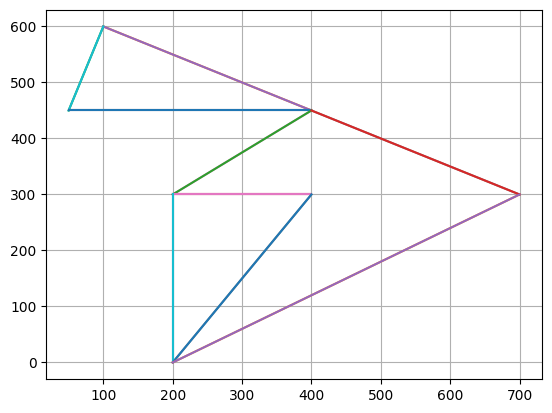

In [166]:
# initialize variables
N = 2 # number of vehicles
M = 7 # number of nodes

# initialize an adjacency matrix to define paths between the nodes

# Adj_mat = np.ones([M+1, M+1])

Adj_mat = np.array([
    [1, 1, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 0, 0, 1, 1],
    [1, 1, 1, 0, 0, 0, 0, 1],
    [0, 1, 0, 1, 1, 1, 0, 1],
    [0, 0, 0, 1, 1, 1, 0, 1],
    [0, 0, 0, 1, 1, 1, 1, 1],
    [0, 1, 0, 0, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1]
])

# Adj_mat = np.array([
#     [1, 1, 0, 1, 1],
#     [1, 1, 1, 0, 1],
#     [0, 1, 1, 1, 1],
#     [1, 0, 1, 1, 1],
#     [1, 1, 1, 1, 1]
# ])

# define the node locations
node_lcn = 100*np.array([
    [1, 6],
    [4, 4.5],
    [0.5, 4.5],
    [2, 3],
    [4, 3],
    [2, 0],
    [7, 3]
])

# define node collision avoid tolerances
node_tol = np.array([
    [3.0],
    [4.5],
    [2.0],
    [1.0],
    [2.4],
    [3.1],
    [2.2]
])

# node_lcn = np.array([
#     [0, 0],
#     [600, 100],
#     [800, -50],
#     [300, -40]
# ])

# define the speed limits for every vehicle
speed_lim = np.array([
    [5, 35],
    [5, 35]
]) # [v_min, v_max] for all v

# initial and final nodes of all the uavs (dimension = N)
init_nodes = [2, 8]
stop_nodes = [7, 2]

# initialize annealing parameter
beta = 1e-10

# create an instance of FLPO class
flpo = FLPO(N, M, Adj_mat, node_lcn, node_tol, speed_lim, init_nodes, stop_nodes, beta)
print('\n -- FLPO Stages -- \n' , flpo.stages)
print('\n -- FLPO Associations -- \n' , flpo.asn_pb)
print('\n -- FLPO Path connections -- \n' , flpo.can_transit)
print('\n -- Cost transitions -- \n', flpo.cost_transit)
print('\n -- Minimum Transition Time Matrix -- \n' , flpo.dt_min)
print('\n -- Maximum Transition Time Matrix -- \n' , flpo.dt_max)
for i in flpo.node_id:
    id_i = flpo.node_id.index(i)
    plt.plot(node_lcn[id_i,0], node_lcn[id_i,1], )
    for j in flpo.node_id:
        id_j = flpo.node_id.index(j)
        if i != j and flpo.Adj_mat[id_i,id_j] == 1:
            # plot a line between i and j 
            plt.plot([node_lcn[id_i, 0], node_lcn[id_j, 0]] , [node_lcn[id_i, 1], node_lcn[id_j, 1]])
plt.grid()

In [168]:
# initialize probability associations and time schedule parameters

x0 = np.array([0, 40, 30, 60, 70, 50, 90, 110, 34, 76, 98, 0, 67, 89])
# [  0.         991.55807441 999.99999393  10.10723717]
flpo.schedule = flpo.wrap_schedules(x0)

# annealing
flpo.beta = 1e-10
lb, ub = flpo.bounds_schedules()
# flpo.asn_pb_gibbs()
# print(lb, ub)
# flpo.train(x0, Bounds(lb, ub))

while flpo.beta <= 100:
    print('beta = ' , flpo.beta)
    flpo.train(x0, Bounds(lb, ub))
    x0 = flpo.flat_schedules(flpo.schedule)
    flpo.beta = 10*flpo.beta

print(flpo.asn_pb)
print(x0)

beta =  1e-10
`xtol` termination condition is satisfied.
Number of iterations: 505, function evaluations: 7695, CG iterations: 2945, optimality: 8.92e+02, constraint violation: 0.00e+00, execution time: 3.7e+01 s.
beta =  1e-09
`gtol` termination condition is satisfied.
Number of iterations: 124, function evaluations: 1590, CG iterations: 383, optimality: 3.12e-16, constraint violation: 0.00e+00, execution time:  7.6 s.
beta =  1e-08
`xtol` termination condition is satisfied.
Number of iterations: 414, function evaluations: 6390, CG iterations: 2145, optimality: 1.30e+01, constraint violation: 0.00e+00, execution time: 3e+01 s.
beta =  1e-07
`xtol` termination condition is satisfied.
Number of iterations: 358, function evaluations: 5640, CG iterations: 1438, optimality: 8.16e-01, constraint violation: 0.00e+00, execution time: 2.7e+01 s.
beta =  1e-06
`xtol` termination condition is satisfied.
Number of iterations: 381, function evaluations: 5730, CG iterations: 2402, optimality: 6.93e

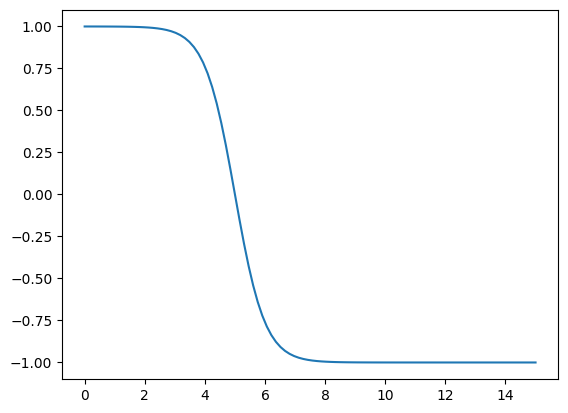

In [148]:
#Test block for penalty function

x = np.linspace(0, 15, 100)
a = -20
b = 2
A = 100
xmin = 5
xmax = 10

def f(x):
    # if x < xmin:
    #     fx = a*x**2 + (1 - 2*a*xmin)*x + a*xmin**2
    # elif (x-xmin)*(x-xmax) <= 0:
    #     fx = x
    # elif x > xmax:
    #     fx = a*x**2 + (1 - 2*a*xmax)*x + a*xmax**2

    fx = np.tanh(5-x)
    return fx

fx = []
for i in x:
    fx = fx + [f(i)]

plt.figure(1)
plt.plot(x,fx)
plt.show()
# print(res)

In [17]:
# test block for vectorization

def func(u, v, w):
    return u+v+w

vec_func = np.vectorize(func)
u = np.array([1,2,3])
v = np.array([[2,3,4],[3,5,6]])
w = np.array([4,5,6])
out = vec_func(u,v,w)
print(out)

[[ 7 10 13]
 [ 8 12 15]]


In [127]:
# test block for kronecker product

mat = np.array([[1,3,4,5],[2,5,3,6],[9,5,6,4]])
vec = np.array([[1],[1],[1]])
kron = np.kron(vec, mat)
print(kron)
print(np.ones([4,1]))
print(np.sum(mat))

[[1 3 4 5]
 [2 5 3 6]
 [9 5 6 4]
 [1 3 4 5]
 [2 5 3 6]
 [9 5 6 4]
 [1 3 4 5]
 [2 5 3 6]
 [9 5 6 4]]
[[1.]
 [1.]
 [1.]
 [1.]]
53
